# Fidelity & Signal Separation Analysis — Paper Figure Recreation

Recreates the Hellinger fidelity and Signal Separation Index (SSI) figure from the OneBQF paper.
Uses pre-computed fidelity results from `OneBQF/data/fidelity_results.json`.

**Panels:**
- (a) Hellinger fidelity: distribution similarity to noiseless baseline
- (b) Signal Separation Index: track vs noise distinguishability

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import ScalarFormatter
import os

## Analysis Functions

In [2]:
def parse_scenario_name(scenario):
    """Parse '3L_2T' -> (3, 2)."""
    parts = scenario.replace('[', '').replace(']', '').split('_')
    return int(parts[0].replace('L', '')), int(parts[1].replace('T', ''))


def calculate_matrix_size(n_layers, n_tracks):
    """N = (layers - 1) * tracks^2."""
    return (n_layers - 1) * n_tracks**2


def calculate_hellinger_fidelity(dist1, dist2):
    """Hellinger fidelity between two probability distributions."""
    return float(np.sum(np.sqrt(dist1 * dist2)) ** 2)


def identify_track_bins(scenario_data, baseline='H2-1LE',
                        circuit_type='1BIT_2bin_2level', threshold=1e-10):
    """Identify bins corresponding to valid tracks from noiseless baseline."""
    baseline_mean = np.array(
        scenario_data[baseline][circuit_type]['normalized_vectors']['mean'])
    return baseline_mean > threshold


def calculate_ssi(measured_dist, track_mask):
    """Signal Separation Index: mean(track bins) / mean(top noise bins)."""
    track_probs = measured_dist[track_mask]
    noise_probs = measured_dist[~track_mask]
    if len(track_probs) == 0 or len(noise_probs) == 0:
        return np.nan
    mean_track = np.mean(track_probs)
    n_top = min(len(track_probs), len(noise_probs))
    mean_noise = np.mean(np.sort(noise_probs)[-n_top:])
    if mean_noise < 1e-15:
        return np.inf if mean_track > 1e-15 else 1.0
    return mean_track / mean_noise


def compute_hellinger_with_errors(results, baseline='H2-1LE',
                                  ct='1BIT_2bin_2level', n_boot=1000):
    """Bootstrap Hellinger fidelity vs noiseless baseline."""
    out = {}
    for scenario, sdata in results.items():
        out[scenario] = {}
        bl_mean = np.array(sdata[baseline][ct]['normalized_vectors']['mean'])
        bl_std = np.array(sdata[baseline][ct]['normalized_vectors']['std'])
        for emu in sdata:
            if emu == baseline:
                continue
            em_mean = np.array(sdata[emu][ct]['normalized_vectors']['mean'])
            em_std = np.array(sdata[emu][ct]['normalized_vectors']['std'])
            samples = []
            for _ in range(n_boot):
                bl = np.maximum(0, np.random.normal(bl_mean, bl_std))
                bl /= bl.sum()
                em = np.maximum(0, np.random.normal(em_mean, em_std))
                em /= em.sum()
                samples.append(calculate_hellinger_fidelity(bl, em))
            out[scenario][emu] = {'mean': np.mean(samples), 'std': np.std(samples)}
    return out


def compute_ssi_with_errors(results, baseline='H2-1LE',
                            ct='1BIT_2bin_2level', n_boot=1000):
    """Bootstrap SSI vs noiseless baseline."""
    out = {}
    for scenario, sdata in results.items():
        out[scenario] = {}
        mask = identify_track_bins(sdata, baseline, ct)
        for emu in sdata:
            if emu == baseline:
                continue
            em_mean = np.array(sdata[emu][ct]['normalized_vectors']['mean'])
            em_std = np.array(sdata[emu][ct]['normalized_vectors']['std'])
            samples = []
            for _ in range(n_boot):
                em = np.maximum(0, np.random.normal(em_mean, em_std))
                em /= em.sum()
                ssi = calculate_ssi(em, mask)
                if not np.isinf(ssi) and not np.isnan(ssi):
                    samples.append(ssi)
            out[scenario][emu] = {
                'mean': np.mean(samples) if samples else np.nan,
                'std': np.std(samples) if samples else np.nan,
            }
    return out

## Load Data & Compute Metrics

In [3]:
DATA_DIR = Path(r'C:\Users\GeorgeWilliam\Documents\GitHub\OneBQF\data')

with open(DATA_DIR / 'fidelity_results.json', 'r') as f:
    tracking_results = json.load(f)

print(f"Scenarios: {list(tracking_results.keys())}")
for s in tracking_results:
    print(f"  {s}: {list(tracking_results[s].keys())}")

# Compute metrics with bootstrap errors
hellinger = compute_hellinger_with_errors(tracking_results, n_boot=1000)
ssi = compute_ssi_with_errors(tracking_results, n_boot=1000)

# Sort scenarios by (n_tracks, n_layers)
scenarios = sorted(hellinger.keys(),
                   key=lambda s: (parse_scenario_name(s)[1], parse_scenario_name(s)[0]))

x_positions = []
x_tick_labels = []
for sc in scenarios:
    nl, nt = parse_scenario_name(sc)
    x_positions.append(calculate_matrix_size(nl, nt))
    x_tick_labels.append(f'{nt}T\n{nl}L')

print(f"\nX positions (matrix sizes): {x_positions}")

Scenarios: ['3L_2T', '5L_2T', '3L_4T', '5L_4T', '3L_8T']
  3L_2T: ['H2-1LE', 'H2-Emulator', 'Qiskit-Pittsburgh', 'Qiskit-Fez', 'Qiskit-Torino']
  5L_2T: ['H2-1LE', 'H2-Emulator', 'Qiskit-Pittsburgh', 'Qiskit-Fez', 'Qiskit-Torino']
  3L_4T: ['H2-1LE', 'H2-Emulator', 'Qiskit-Pittsburgh', 'Qiskit-Fez', 'Qiskit-Torino']
  5L_4T: ['H2-1LE', 'H2-Emulator', 'Qiskit-Pittsburgh', 'Qiskit-Fez', 'Qiskit-Torino']
  3L_8T: ['H2-1LE', 'H2-Emulator', 'Qiskit-Pittsburgh', 'Qiskit-Fez', 'Qiskit-Torino']

X positions (matrix sizes): [8, 16, 32, 64, 128]


## Generate Figure

Saved to Plots/


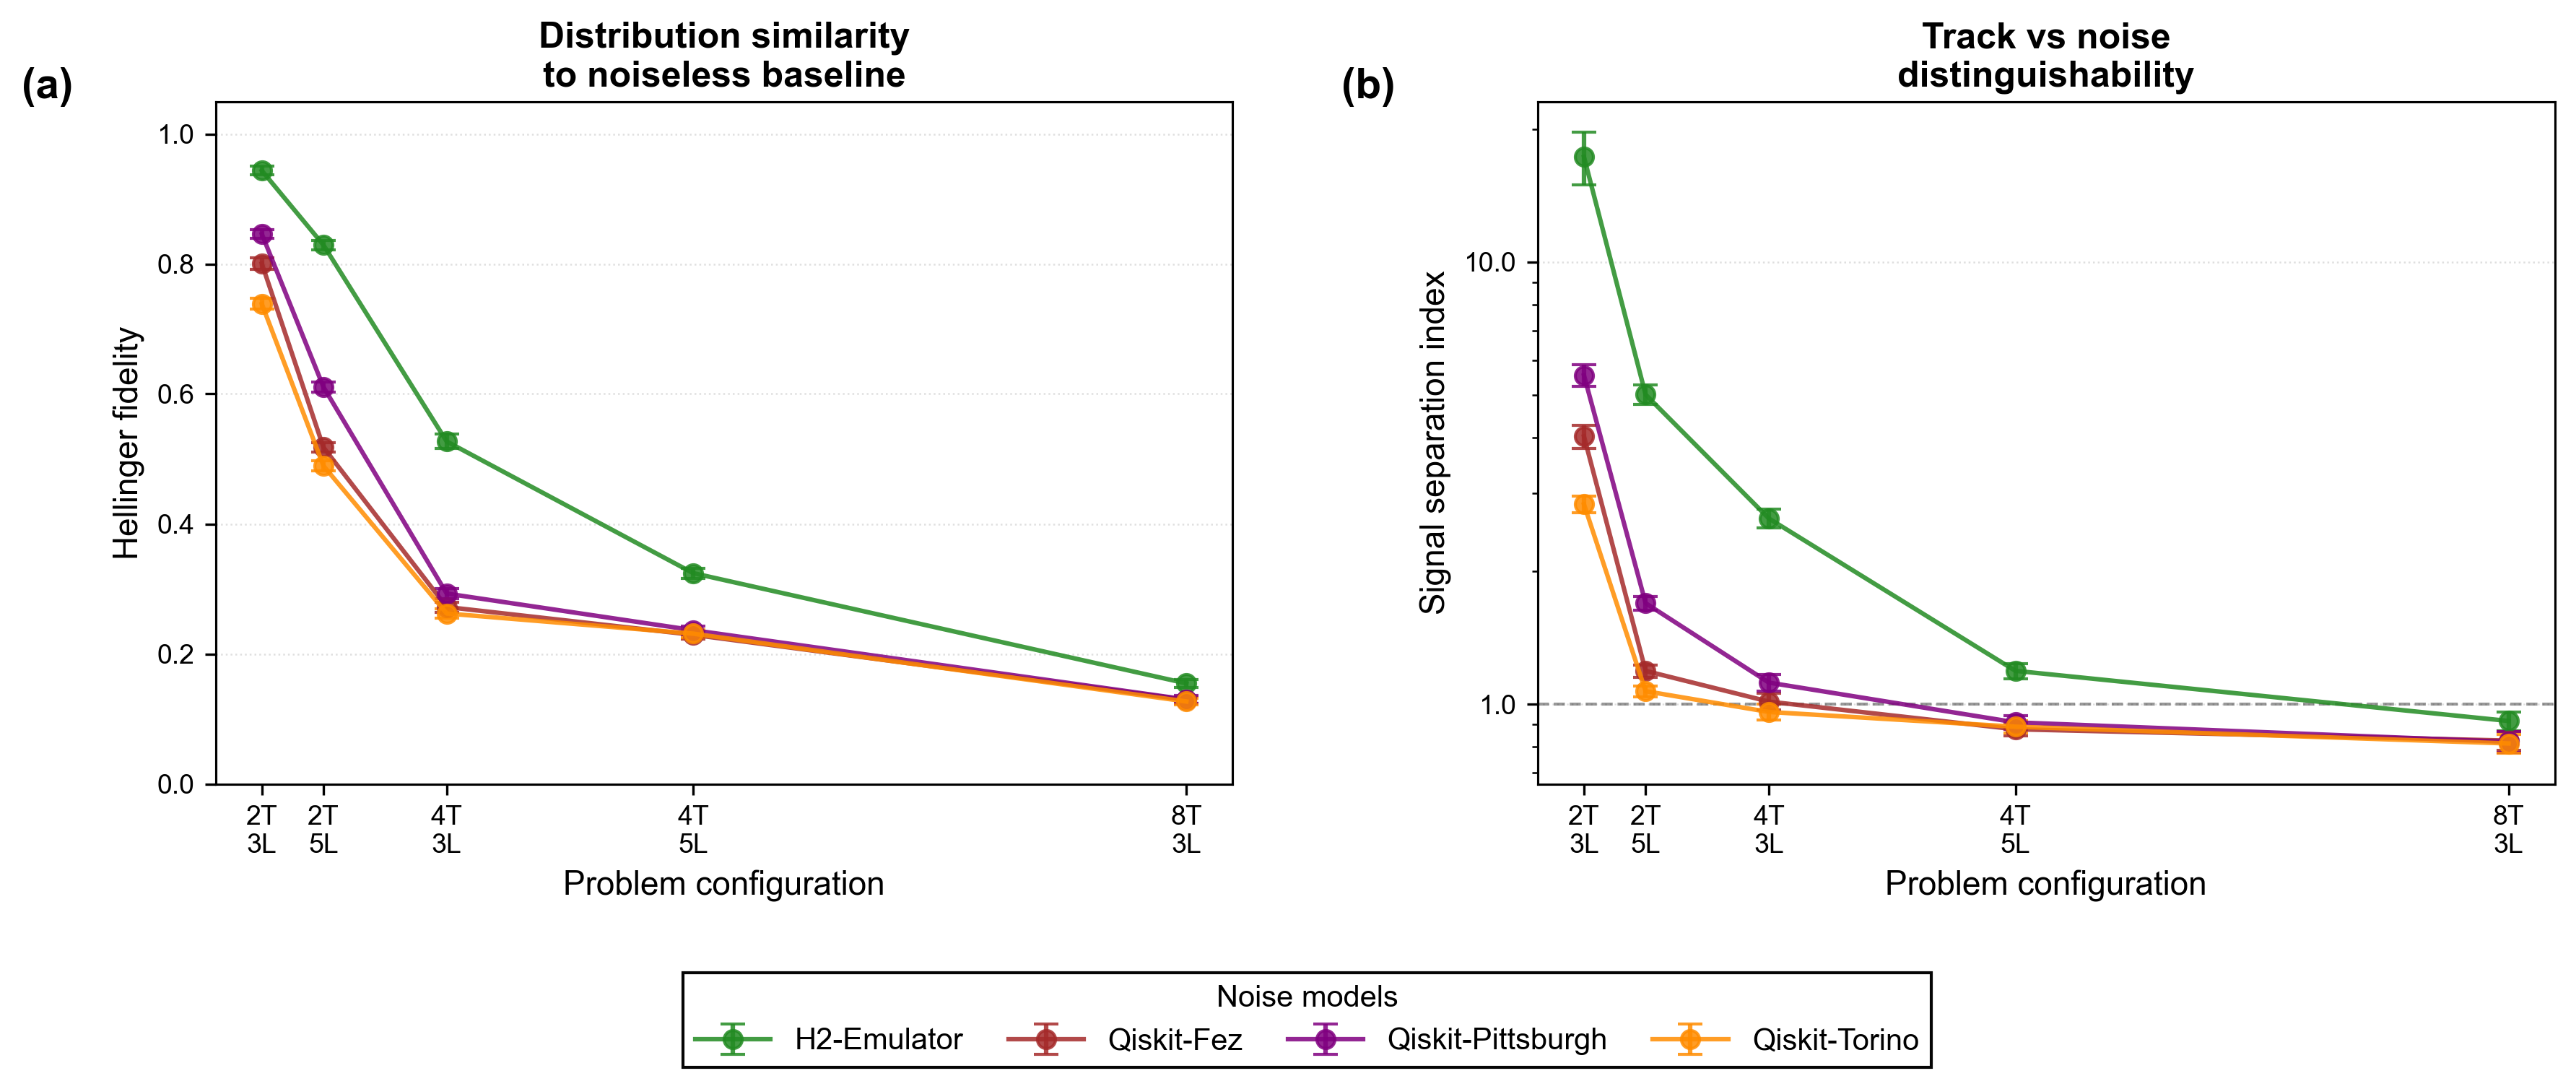

In [4]:
emulator_colors = {
    'H1-Emulator': 'royalblue',
    'H2-Emulator': 'forestgreen',
    'Qiskit-Torino': 'darkorange',
    'Qiskit-Marrakesh': 'crimson',
    'Qiskit-Pittsburgh': 'purple',
    'Qiskit-Fez': 'brown',
}

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica']
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.75

fig = plt.figure(figsize=(12, 5), dpi=300)
gs = fig.add_gridspec(1, 2, hspace=0.25, wspace=0.30,
                      left=0.08, right=0.98, top=0.88, bottom=0.25)
handles, labels = [], []

# --- Panel (a): Hellinger Fidelity ---
ax_h = fig.add_subplot(gs[0, 0])
for emu in sorted(hellinger[scenarios[0]].keys()):
    color = emulator_colors.get(emu, 'gray')
    means = [hellinger[sc].get(emu, {}).get('mean', np.nan) for sc in scenarios]
    stds  = [hellinger[sc].get(emu, {}).get('std', 0) for sc in scenarios]
    line = ax_h.errorbar(x_positions, means, yerr=stds,
                         marker='o', lw=1.5, ms=6, capsize=4, capthick=1,
                         label=emu, color=color, alpha=0.85)
    if emu not in labels:
        handles.append(line)
        labels.append(emu)

ax_h.set_xlabel('Problem configuration', fontsize=11)
ax_h.set_ylabel('Hellinger fidelity', fontsize=11)
ax_h.set_title('Distribution similarity\nto noiseless baseline',
               fontsize=12, fontweight='bold', pad=5)
ax_h.set_xticks(x_positions)
ax_h.set_xticklabels(x_tick_labels, fontsize=9)
ax_h.set_ylim(0, 1.05)
ax_h.grid(True, alpha=0.4, axis='y', ls=':', lw=0.6)
ax_h.tick_params(labelsize=9)
ax_h.text(-0.14, 1.05, '(a)', transform=ax_h.transAxes,
          fontsize=14, fontweight='bold', va='top', ha='right')

# --- Panel (b): SSI ---
ax_s = fig.add_subplot(gs[0, 1])
for emu in sorted(ssi[scenarios[0]].keys()):
    color = emulator_colors.get(emu, 'gray')
    means = [ssi[sc].get(emu, {}).get('mean', np.nan) for sc in scenarios]
    stds  = [ssi[sc].get(emu, {}).get('std', 0) for sc in scenarios]
    ax_s.errorbar(x_positions, means, yerr=stds,
                  marker='o', lw=1.5, ms=6, capsize=4, capthick=1,
                  label=emu, color=color, alpha=0.85)

ax_s.set_xlabel('Problem configuration', fontsize=11)
ax_s.set_ylabel('Signal separation index', fontsize=11)
ax_s.set_title('Track vs noise\ndistinguishability',
               fontsize=12, fontweight='bold', pad=5)
ax_s.set_xticks(x_positions)
ax_s.set_xticklabels(x_tick_labels, fontsize=9)
ax_s.set_yscale('log')
ax_s.axhline(y=1, color='black', ls='--', lw=1.0, alpha=0.4)
ax_s.grid(True, alpha=0.4, axis='y', ls=':', lw=0.6)
ax_s.tick_params(labelsize=9)
ax_s.yaxis.set_major_formatter(ScalarFormatter())
ax_s.ticklabel_format(axis='y', style='plain')
ax_s.text(-0.14, 1.05, '(b)', transform=ax_s.transAxes,
          fontsize=14, fontweight='bold', va='top', ha='right')

# Legend
fig.legend(handles, labels, loc='lower center',
           bbox_to_anchor=(0.5, -0.02),
           fontsize=10, framealpha=0.98,
           title='Noise models', title_fontsize=10,
           ncol=len(handles), borderaxespad=0.3,
           columnspacing=1.5, handlelength=2.5,
           edgecolor='black', fancybox=False, frameon=True)

# Save
os.makedirs('Plots', exist_ok=True)
plt.savefig('Plots/hellinger_ssi_analysis.pdf', dpi=600, bbox_inches='tight')
plt.savefig('Plots/hellinger_ssi_analysis.jpeg', dpi=600, bbox_inches='tight')
print('Saved to Plots/')
plt.show()

plt.rcParams.update(plt.rcParamsDefault)